# Modernizing Portfolio Analytics - Example ETL
* Loading Data From a Database Connection
* Exploratory Data Analysis
* Data Engineering & Transformations
* Fitting a Model
* Writing Results to a Database
* Connecting Power BI to Database

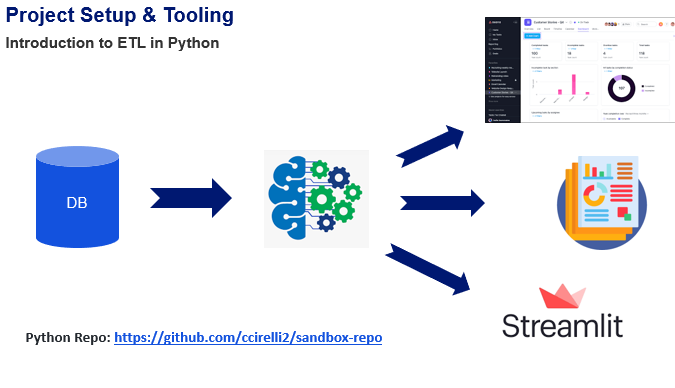

# DataSet
* Name: Wine recognition dataset
* This is a copy of UCI ML Wine recognition datasets.
* https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
* Description: The data is the results of a chemical analysis of wines grown in the same
region in Italy by three different cultivators. There are thirteen different
measurements taken for different constituents found in the three types of
wine.

# I. SETUP

### Import Packages

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from decouple import config as d_config
import logging
import warnings

### Declare Directories

In [2]:
# Declare Directories
DIR_ROOT = r'C:\\Users\\ccirelli\\OneDrive - American International Group, Inc\\Desktop\\GitHub\\sandbox-repo'
DIR_DATA = os.path.join(DIR_ROOT, 'data')
DIR_SRC = os.path.join(DIR_ROOT, "src")
DIR_RESULTS = os.path.join(DIR_ROOT, "results")

# Set environment variables
os.environ['DIR_ROOT'] = DIR_ROOT
os.environ['DIR_SRC'] = DIR_SRC
os.environ['DIR_DATA'] = DIR_DATA
os.environ['DIR_RESULTS'] = DIR_RESULTS

### Import Product Specific Libraries

In [12]:
# Import Project Modules
from src.connections import mysql_connect
from src import utilities as m_utils
from src.utilities import my_timeit
from src.queries import query_wine, insert_dt_opt_depth
from src import visualizations as my_viz
from src import transformations as my_trans
from src import models as m_models

# Package Settings
pd.set_option('display.max_columns', None)
logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

### Connect to Database

In [4]:
# Instantiate Connection to Database
my_conn = mysql_connect(
            host=d_config("MYSQL_HOST"),
            user_name=d_config("MYSQL_USER"),
            password=d_config("MYSQL_PASSWORD"),
            database="sandbox_onsite"
        )

INFO:root:Starting function mysql_connect
INFO:root:Connection established successfully to sandbox_onsite for user root
INFO:root:mysql_connect finished.  Duration-sec: 0.428905 | Duration-min: 0.01
INFO:root:



### Load Data

In [6]:
# Query String
db_tables = pd.read_sql(sql="SHOW TABLES;", con=my_conn)

# Load Data Into Pandas DataFrame
df_wine = pd.read_sql(sql="SELECT * FROM wine_raw;", con=my_conn)

# II. Exploratory Data Analysis
* Inspect data types
* Inspect data cardinality
* Missing Data
* Distribution of both dependent and independent variables

### Data Dimensions

In [8]:
df_wine.shape

(180, 14)

### Inspect Data

In [7]:
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


### Inspect Datatypes

In [9]:
df_wine.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                          float64
dtype: object

### Null Values

In [10]:
df_wine.isna().sum()

alcohol                         1
malic_acid                      1
ash                             1
alcalinity_of_ash               1
magnesium                       1
total_phenols                   1
flavanoids                      1
nonflavanoid_phenols            1
proanthocyanins                 1
color_intensity                 1
hue                             1
od280/od315_of_diluted_wines    1
proline                         1
target                          1
dtype: int64

### Distribution of Variables

INFO:root:wine_hist_alcohol.png written to C:\\Users\\ccirelli\\OneDrive - American International Group, Inc\\Desktop\\GitHub\\sandbox-repo\results


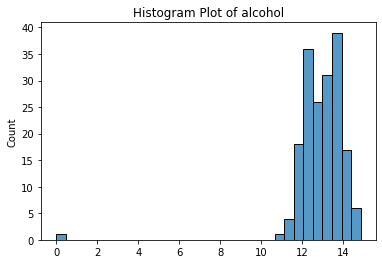

In [13]:
my_viz.plot_distribution(
    data_frame=df_wine,
    column_name="alcohol",
    save_fig=True,
    directory=DIR_RESULTS)

INFO:root:wine_hist_malic_acid.png written to C:\\Users\\ccirelli\\OneDrive - American International Group, Inc\\Desktop\\GitHub\\sandbox-repo\results


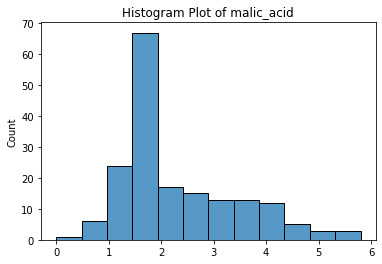

In [14]:
my_viz.plot_distribution(
    data_frame=df_wine,
    column_name="malic_acid",
    save_fig=True,
    directory=DIR_RESULTS)

### Visualize Correlations

INFO:root:wine-correlation-matrix.png saved to C:\\Users\\ccirelli\\OneDrive - American International Group, Inc\\Desktop\\GitHub\\sandbox-repo\results


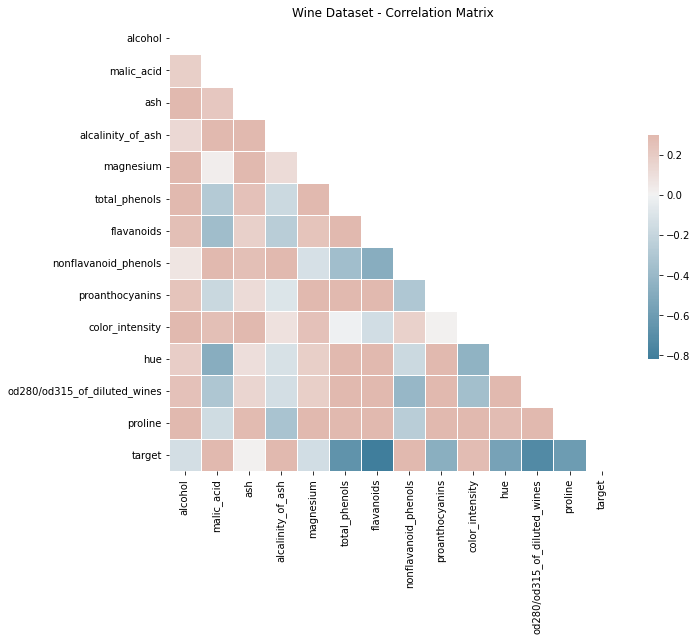

In [15]:
my_viz.correlation_matrix(df_wine, save_fig=True, directory=DIR_RESULTS)

# III. Data Engineering + Transformations
* Remove Null Values
* Convert Target Value to Int

### Drop Null Values

In [16]:
data_frame = my_trans.remove_nan_rows(data_frame=df_wine)

INFO:root:Starting function remove_nan_rows
INFO:root:Dimensions prior to transformation => (180, 14)
INFO:root:Dimensions after to transformation => (179, 14)
INFO:root:remove_nan_rows finished.  Duration-sec: 0.006982 | Duration-min: 0.0
INFO:root:



### Convert Taret To Int

In [17]:
data_frame["target"] = list(map(lambda x: int(x), data_frame.target.values))

# IV. Train Model
* Fit
* Get Optimal Tree Depth


### Fit Model

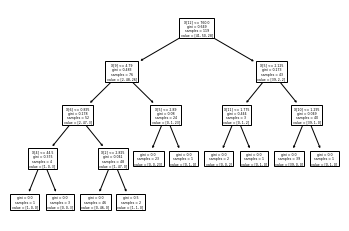

[[17  2  0]
 [ 2 16  3]
 [ 0  3 17]]


In [20]:
accuracy = m_models.single_fit_decision_tree(
    data_frame=data_frame,
    pplot_tree=True,
    pplot_confusion_matrix=True,
    max_depth=4)

### Get Optimal Depth

In [21]:
df_accuracy = m_models.optimize_max_trees(data_frame, max_depth=12, result_to_file=False, directory=DIR_RESULTS)

Text(0, 0.5, 'Accuracy')

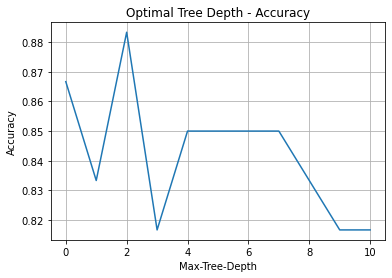

In [27]:
plt.plot(df_accuracy.Test_Accuracy)
plt.title("Optimal Tree Depth - Accuracy")
plt.grid(b=True)
plt.xlabel("Max-Tree-Depth")
plt.ylabel("Accuracy")

# V. Write Results to Database

In [28]:
"""
insert_dt_opt_depth(data_frame=df_accuracy, max_depth_col_name="Max_Depth", accuracy_col_name="Test_Accuracy",
                    conn=my_conn)
                    """

'\ninsert_dt_opt_depth(data_frame=df_accuracy, max_depth_col_name="Max_Depth", accuracy_col_name="Test_Accuracy",\n                    conn=my_conn)\n                    '